***Классификация пород кошек и собак по лицу***

Для начала загрузим упрощенный датасет - [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [3]:
#lib import
from keras import utils
from keras import layers
from keras.models import Sequential
from keras.metrics import SparseTopKCategoricalAccuracy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
from pathlib import Path

In [4]:
#dataset loading
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
data = Path(utils.get_file('petfaces', origin=url, untar=True))

In [5]:
#dividing to test and train 
img_size = 256, 256

train_set = utils.image_dataset_from_directory (
    data, 
    validation_split=0.2, 
    subset='training',
    seed=3000,
    image_size=img_size,
    batch_size=32)

test_set = utils.image_dataset_from_directory (
    data, 
    validation_split=0.2, 
    subset='validation',
    seed=3000, 
    image_size=img_size,
    batch_size=32)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Далее разделим полученный датасет на классы: кошки и собаки (cats/dogs)

In [6]:
class_names = train_set.class_names

class_cats = []
class_dogs = []

for _ in range(len(class_names)):
    if class_names[_].startswith('cat'):
        class_cats.append(_)
    if class_names[_].startswith('dog'):
        class_dogs.append(_)

train_set = train_set.cache().shuffle(3000 // 2).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
model = Sequential()

model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(8, 3, activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(16,  3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names)))
model.add(layers.Softmax())

C:\Users\aleks\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
top3_accuracy = SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

start_time = time.time()

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', top3_accuracy])

epochs = 40

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0556 - loss: 7.4115 - top3_accuracy: 0.1400 - val_accuracy: 0.1745 - val_loss: 2.9684 - val_top3_accuracy: 0.3427
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2546 - loss: 2.6609 - top3_accuracy: 0.4951 - val_accuracy: 0.3910 - val_loss: 2.1476 - val_top3_accuracy: 0.6495
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.4608 - loss: 1.8461 - top3_accuracy: 0.7190 - val_accuracy: 0.4502 - val_loss: 1.8857 - val_top3_accuracy: 0.7103
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6222 - loss: 1.2419 - top3_accuracy: 0.8381 - val_accuracy: 0.4875 - val_loss: 1.8146 - val_top3_accuracy: 0.7383
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.7193 - loss: 0.9532 - top3_accuracy: 0.9008 - val_accuracy: 0.5327 - val_loss: 1.7775 - val_top3_accuracy: 0.7570
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8260 - loss: 0.5945 - top3_accura

In [55]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_top3_accuracy = history.history['top3_accuracy']
test_top3_accuracy = history.history['val_top3_accuracy']

end_time = time.time()

In [56]:
def graf(title, label1, label2, epochs, val1, val2):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), val1, label=label1)
    plt.plot(range(epochs), val2, label=label2)
    plt.legend()
    plt.grid()
    plt.title(title)

    plt.show()

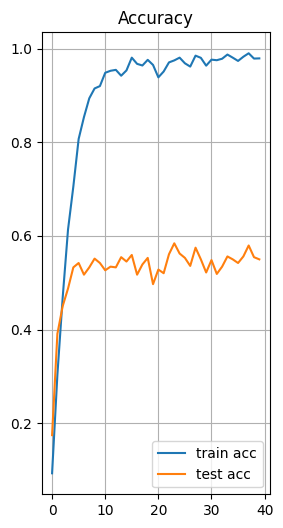

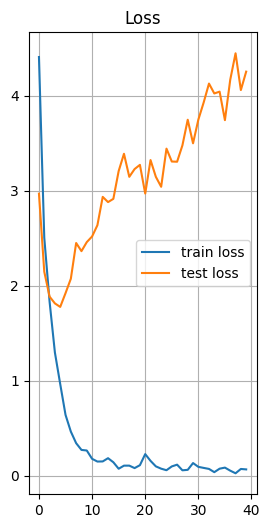

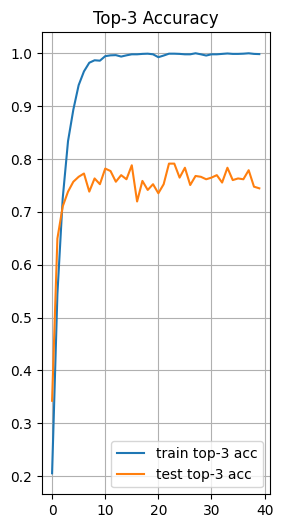

In [57]:
graf('Accuracy', 'train acc', 'test acc', epochs, train_accuracy, test_accuracy)
graf('Loss', 'train loss', 'test loss', epochs, train_loss, test_loss)
graf('Top-3 Accuracy', 'train top-3 acc', 'test top-3 acc', epochs, train_top3_accuracy, test_top3_accuracy)

In [58]:
correct, total = 0, 0

for x, y in test_set:
    y_pred = np.argmax(model.predict(x), axis=1)
    correct_cats = sum([y_pred[i] in class_cats and y[i] in class_cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] in class_dogs and y[i] in class_dogs for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += len(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [59]:
y_real = np.array([])
y_pred = np.array([])

for x, y in test_set:
    y_real = np.concatenate((y_real, y), axis=None)
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    

confusion_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names], columns = [i for i in class_names])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


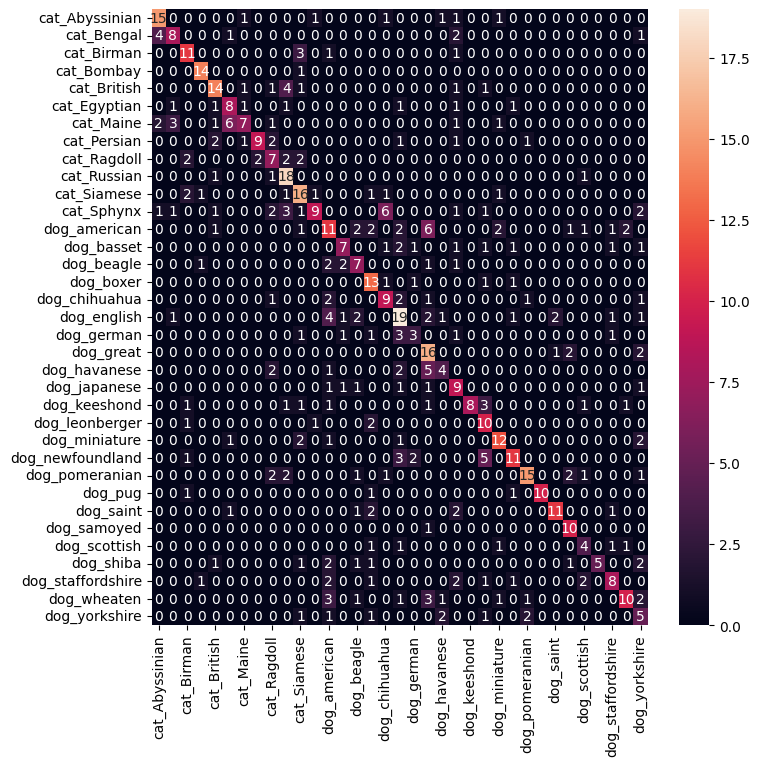

In [60]:
plt.figure(figsize = (8, 8))
sn.heatmap(df_cm, annot=True)
plt.show()

In [61]:
print('\nFinal train accuracy:', train_accuracy[epochs - 1])
print('Final test accuracy:', test_accuracy[epochs - 1])
print('\nFinal train loss:', train_loss[epochs - 1])
print('Final test loss:', test_loss[epochs - 1])
print('\nBinary classification accuracy:', correct / total)
print('\nFinal train top-3 accuracy:', train_top3_accuracy[epochs - 1])
print('Final test top-3 accuracy:', test_top3_accuracy[epochs - 1])
print("\ntime =", end_time - start_time, '\n')


Final train accuracy: 0.9789801239967346
Final test accuracy: 0.5498442649841309

Final train loss: 0.06877516210079193
Final test loss: 4.251830101013184

Binary classification accuracy: 0.9065420560747663

Final train top-3 accuracy: 0.9984429478645325
Final test top-3 accuracy: 0.7445482611656189

time = 835.5061597824097 

